### Sustainability Aware Asset Management: **Group A: North America // Scope 1 + 2**

In [128]:
## Packages lists:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1)
import datetime as dt
from scipy.optimize import minimize

#### Import and Clean the Data frames

In [2]:
## Import the Data:
companies = pd.read_excel("Data/Static.xlsx", index_col=1)
monthly_tri = pd.read_excel("Data/DS_RI_T_USD_M.xlsx")
yearly_tri = pd.read_excel("Data/DS_RI_T_USD_Y_CAI.xlsx")
market_value_m = pd.read_excel("Data/DS_MV_USD_M.xlsx")
market_value_y = pd.read_excel("Data/DS_MV_USD_Y_CAI.xlsx")
risk_free = pd.read_excel("Data/Risk_Free_Rate.xlsx", index_col=0)
scope1_int = pd.read_excel("Data/TC_Scope1Intensity.xlsx")
scope1_em = pd.read_excel("Data/TC_Scope1.xlsx")
scope2_int = pd.read_excel("Data/TC_Scope2Intensity.xlsx")
scope2_em = pd.read_excel("Data/TC_Scope2.xlsx")
scope3_int = pd.read_excel("Data/TC_Scope3Intensity.xlsx")
scope3_em = pd.read_excel("Data/TC_Scope3.xlsx")

In [3]:
## Filter out the Non North American Companies and Clean the dataframes:
companies = companies[companies["Region"] == "AMER"]

list_dataframes = [monthly_tri, yearly_tri, market_value_m, market_value_y, scope1_int, scope1_em, scope2_int, scope2_em, scope3_int, scope3_em]

def filter_nacompanies(list_dataframes):
    for i in range(len(list_dataframes)):
        dataframe = list_dataframes[i]
        ## Filter out the Non North American Companies:
        dataframe = dataframe[dataframe["ISIN"].isin(companies.index)]
        # Replace the Company Names to make it match with the companies dataframe:
        dataframe.iloc[:,1] = companies.iloc[:,0].values
        # Drop the ISIN column and set the Company Names as the index:
        dataframe = dataframe.iloc[:, 1:].set_index("NAME")
        list_dataframes[i] = dataframe
    return list_dataframes

list_dataframes = filter_nacompanies(list_dataframes)

monthly_tri, yearly_tri, market_value_m, market_value_y, scope1_int, scope1_em, scope2_int, scope2_em, scope3_int, scope3_em= list_dataframes

## Change the Date format to datetime:
market_value_m.columns = pd.to_datetime(market_value_m.columns)
monthly_tri.columns = pd.to_datetime(monthly_tri.columns)

In [4]:
## Computing the Monthly Returns and replace the first NaN row with the mean of each column
df_m = monthly_tri.T.pct_change()
sample_means = df_m.iloc[1:, :].mean()
df_m = df_m.fillna(sample_means)

#### **Part I - Standard Asset Allocation**
##### Part 1.1
* Compute the minimum variance portfolio out of sample using as first sample the first 6 years of monthly returns (from Jan. 2000 to Dec. 2005). Then, roll the window by one year and iterate until the end of the sample, so that the portfolio is rebalanced every year from Dec. 2005 to Dec. 2021

* Compute the ex post-performance of the portfolio

The maximization problem is the following:

$$\min_{{{\alpha_{Y}}}}\quad \sigma^{2}_{p,Y+1} = \alpha'_{Y}\Sigma_{Y+1}\alpha_{Y}$$

$$\text{s.t.}\quad \alpha'_{Y}e = 1$$

$$\text{s.t.}\quad  \alpha_{i,Y} \ge 0 \quad \text{for all i}$$

In [5]:
# Compute the Covariance Matrix for a given period
def compute_covmat(df, start, end):
    ## Create the sample for the corresponding window:
    sample_m = df_m[df_m.index.isin(pd.date_range(start, end))]
    ## Compute the expected returns:
    mu_hat = sample_m.mean(axis=0)
    ## Compute the excess returns:
    excess_returns = sample_m.subtract(mu_hat.values.squeeze(), axis=1)
    ## Compute the covariance matrix:
    covmat = (excess_returns.T @ excess_returns) * 1/sample_m.shape[0]

    return covmat

# Objective Function (what we want to minimize)
def portfolio_variance(weights, covmat):
    return weights.T @ covmat @ weights

# Full Investment Constraint (sum of weights = 1)
def full_investment_constraint(weights):
    return np.sum(weights) - 1

# Number of Assets Constraint
n_assets = len(df_m.columns)

# Long Only Constraint (weights >= 0)
bounds = [(0, 1)] * n_assets

# Initial Guess (Equally Weighted Portfolio)
initial_weights = np.ones(n_assets) / n_assets

# Initial Date Range
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2005, 12, 31)

# Create a list to store the optimal weights
weights_df = pd.DataFrame(index=df_m.columns)

# 1-year rolling window minimium variance portfolio optimization
for i in range(17):
    covmat = compute_covmat(df_m, start, end)

    result = minimize(portfolio_variance, initial_weights, args=(covmat,), constraints={'type': 'eq', 'fun': full_investment_constraint}, bounds=bounds)

    # Get optimal weights
    optimal_weights = result.x
    weights_df[end.year + 1] = optimal_weights

    # Roll the window forward by 1 year
    start = start.replace(year=start.year+1)
    end = end.replace(year=end.year+1)

    initial_weights = optimal_weights.copy()

# Display the optimal weights for asset for each year
np.round(weights_df, 7).head()

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
NAME,,,,,,,,,,,,,,,,,
Schlumberger Limited,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Arch Capital Group Ltd.,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"Everest Group, Ltd.",0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.002859,0.027223,0.060978,0.054673,0.065398
Nabors Industries Ltd.,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
RenaissanceRe Holdings Ltd.,0.012194,0.01862,0.014906,0.0,0.0,0.0,0.0,0.0,0.0,0.020509,0.024475,0.018639,0.016065,0.023166,0.027833,0.002266,0.011535


In [6]:
def check_constraints(weights):
    ## Check if each column is equal to 1 (Full investment constraint):
    if (np.round(weights_df.sum(axis=0),6) == 1).any():
        print('No error: Full investment constraint has been correctly applied.')
    else:
        print('Error: Full investment constraint has not been correctly applied. Try again!')

    ## Check if all the weights are positive and between 0 and 1 (Long Only Constraint):
    if ((weights_df.min() == 0).any()) & ((weights_df.max() <= 1).any()):
        print('No error: Long Only Constraint has been correctly applied.')
    else:
        print('Error: Long Only Constraint has not been correctly applied. Try again!')

check_constraints(weights_df)

No error: Full investment constraint has been correctly applied.
No error: Long Only Constraint has been correctly applied.


In [7]:
## Transform the weights dataframe to an alphas dataframe, which contains the monthly intermediate weights of the portfolio:
def from_weights_to_alphas(weights_df):
    # Initialize an empty DataFrame to hold all alphas
    alphas_df = pd.DataFrame()

    for year in range(2006, 2022+1):
        # Create a subdataframe for the year Y:
        alpha_subdf = pd.DataFrame(index=df_m.columns, columns=pd.date_range(dt.datetime(year-1, 12, 31), dt.datetime(year, 11, 30), freq='M'))

        # Replace the first column by the weights found for the year Y
        alpha_subdf.iloc[:, 0] = weights_df[year]

        # Create a subdataframe which contains each stock's return during the year Y
        returns_subdf = df_m[df_m.index.isin(pd.date_range(dt.datetime(year, 1, 1), dt.datetime(year, 12, 31)))].T

        # Complete the alpha_subdf
        for date in range(1, 12):
            for stock in range(df_m.shape[1]):
                stock_ret = returns_subdf.iloc[stock, date-1]
                pf_ret = returns_subdf.iloc[:, date-1] @ alpha_subdf.iloc[:, date-1]
                alpha_subdf.iloc[stock, date] = alpha_subdf.iloc[stock, date-1] * ((1 + stock_ret) / (1 + pf_ret))
                
        # Append the completed alpha_subdf to alphas_df
        alphas_df = pd.concat([alphas_df, alpha_subdf], axis=1)

    return alphas_df

## Transform the alphas dataframe to a performance dataframe, which contains the monthly performance of the portfolio:
def from_alphas_to_perf(alphas_df):
    ## Filter the monthly returns of each stock from 2006-01-01 to 2022-12-31
    returns = df_m[df_m.index.isin(pd.date_range(dt.datetime(2006, 1, 1), dt.datetime(2022, 12, 31)))].T

    ## Create a list to store the performances of the portfolio for each month
    performances = []

    ## For loop to compute the performance of the portfolio for each month
    for i in range(returns.shape[1]):
        perf = alphas_df.iloc[:,i] @ returns.iloc[:,i]
        performances.append(perf)

    ## Format the performances list into a pandas Series
    return pd.Series(performances, index=returns.columns)

alphas_df = from_weights_to_alphas(weights_df)
performances = from_alphas_to_perf(alphas_df)

performances

2006-01-31    0.030375
2006-02-28    0.020039
2006-03-31    0.020022
2006-04-30    0.013991
2006-05-31   -0.017173
                ...   
2022-08-31   -0.015782
2022-09-30   -0.068650
2022-10-31    0.089971
2022-11-30    0.031337
2022-12-31   -0.050614
Length: 204, dtype: float64

In [8]:
## Compute the characteristics (annualized average return, annualized volatility, sharpe ratio, minimum, maximum, and maximum drawdown)
def pf_characteristics(performances, name):
    global risk_free

    # Monthly average return
    avg_m_ret = performances.mean()

    # Annualized average return
    avg_y_ret = 12 * avg_m_ret
    
    # Monthly volatility
    m_vol = performances.std()

    # Annualized volatility
    y_vol = np.sqrt(12) * m_vol

    # Filter the risk free rate for the corresponding period
    risk_free = risk_free[risk_free.index.isin(performances.index)] / 100

    # Monthly Average Sharpe Ratio
    sharpe_m = ((avg_m_ret - risk_free.mean()) / m_vol).values[0]

    # Annualized Sharpe Ratio
    sharpe_y = np.sqrt(12) * sharpe_m

    # Compute minimum, and maximum performance
    minimum, maximum = np.min(performances), np.max(performances)

    # Compute the Maximum Drawdowns
    cum_ret = (1+performances).cumprod()
    peaks = cum_ret.cummax()
    drawdowns = (cum_ret - peaks) / peaks
    MDD = drawdowns.min()

    data = {
    'Annualized Average Return': [avg_y_ret],
    'Annualized Volatility': [y_vol],
    'Sharpe Ratio': [sharpe_y],
    'Minimum': [minimum],
    'Maximum': [maximum],
    'Maximum Drawdown': [MDD]
    }

    return pd.DataFrame(data, index=[name]).T

In [9]:
characteristics_mv = pf_characteristics(performances, 'P(MV)')
characteristics_mv

,P(MV)
Annualized Average Return,0.101151
Annualized Volatility,0.123384
Sharpe Ratio,0.734039
Minimum,-0.150350
Maximum,0.097626
Maximum Drawdown,-0.353612


##### Part 1.2

* Compute the performance of the value-weighted portfolio
* Compute its characteristics
* Compare the cumulative returns of the minimum-variance and value weighted portfolios.
* Compute and compare their characteristics

The performance of the value-weighted portfolio is computed with:
$$
R_{t+1}^{(vw)} = \sum^{N}_{i=1} w_{i,t} R_{i,t+1}
\quad
\text{where}\quad w_{i,t} = \frac{Cap_{i,t}}{\sum^{N}_{i=1} Cap_{i,t}}
$$

In [10]:
## Compute the monthly value-weighted portfolio weights

monthly_total_marketvalue = market_value_m.sum(axis=0)

weights_vwpf = market_value_m.div(monthly_total_marketvalue, axis=1)
weights_vwpf = weights_vwpf.iloc[:,weights_vwpf.columns.isin(pd.date_range(dt.datetime(2005, 12, 31), dt.datetime(2022, 12, 31)))]

In [11]:
## Compute the value-weighted portfolio performance

returns_stock = df_m[df_m.index.isin(pd.date_range(dt.datetime(2006, 1, 1), dt.datetime(2022, 12, 31)))].T

performances_vwpf = []

for i in range(returns_stock.shape[1]):
    perf = weights_vwpf.iloc[:,i] @ returns_stock.iloc[:,i]
    performances_vwpf.append(perf)

performances_vwpf = pd.Series(performances_vwpf, index=returns_stock.columns)

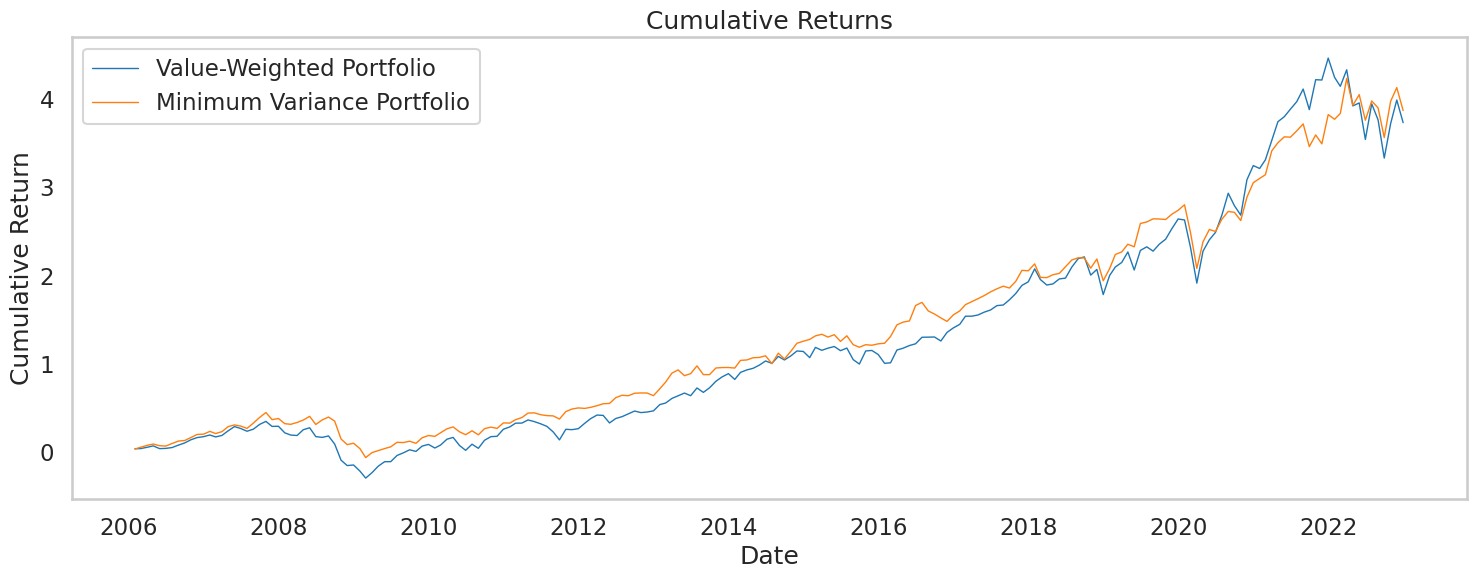

In [140]:
# Plot the cumulative return of the VW and MV portfolios.
def plot_cumulative_returns(dataframes, names):
    plt.figure(figsize=(18, 6))

    for df, name in zip(dataframes, names):
        cum_returns = (1 + df).cumprod() - 1
        plt.plot(cum_returns, label=name, lw=1)

    plt.title('Cumulative Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.grid(False)
    plt.legend()
    plt.show()

plot_cumulative_returns([performances_vwpf, performances], ['Value-Weighted Portfolio', 'Minimum Variance Portfolio'])

In [13]:
# Compare the characteristics of both strategies
characteristics_vw = pf_characteristics(performances_vwpf, 'Value-Weighted Portfolio')

pd.concat([characteristics_mv, characteristics_vw], axis=1)

,P(MV),Value-Weighted Portfolio
Annualized Average Return,0.101151,0.103492
Annualized Volatility,0.123384,0.152565
Sharpe Ratio,0.734039,0.677653
Minimum,-0.150350,-0.168004
Maximum,0.097626,0.124161
Maximum Drawdown,-0.353612,-0.478136


#### **Part II - Asset Allocation with a Carbon Emissions Reduction**

#### 2. Allocation with a $50\%$ Reduction in Carbon Emissions

2.1 Compute the weighted average carbon intensity and the carbon footprint of the portfolio as the amount of annual carbon emissions that can be allocated to the investor per million U.S. dollars invested using the following formulas:

$$
WACI^{(P)}_{Y} = \sum^{N}_{i=1}\alpha_{i,Y}CI_{i,Y} \quad \quad \quad \quad CF_{Y}^{(p)} = \sum^{N}_{i=1} o_{i,Y} E_{i,Y}
$$

In [14]:
def make_carbondata_good(dataframes):
    # Sum them
    data = dataframes[0] + dataframes[1]

    # Filter the data for the corresponding period
    data = data.iloc[:,data.columns.isin(range(2005, 2022+1))]

    # Replace the values missing in 2005 by the next available value
    data.iloc[:,0] = data.iloc[:,0].bfill()

    # Interpolate the values missing in 2014 by the mean of 2013 and 2015
    data.iloc[:,9] = data.iloc[:,9].fillna(data.iloc[:,[8,10]].mean(axis=1))

    return data

carbon_intensity = make_carbondata_good([scope1_int, scope2_int])
carbon_emissions = make_carbondata_good([scope1_em, scope2_em])

In [110]:
def weighted_avg_carbon_int(yearly_weights, portfolio):
    global carbon_intensity
    ## Create a DataFrame to store the WACI for each year
    waci = pd.DataFrame(columns=[f'WACI - {portfolio}'], index=range(2006, 2022+1))

    ## Compute the WACI for each year. We took the weights of the year Y multiplied by the carbon intensity of the year Y-1, as this is information that is not
    ## available at the beginning of the year Y.
    for year in range(2006, 2022+1):
        waci.loc[year] = weights_df[year] @ carbon_intensity[year-1]
    return waci

    
def carbon_footprint(performances, weights_df, portfolio):
    global carbon_emissions
    ## Compute the V_{Y} (Dollar value of the Portfolio at year Y)
    vy = pd.DataFrame(index=range(2005,2022+1), columns=['Portfolio Value (in $)'])
    cumprod = (1+performances).cumprod() * 1_000_000

    for year in range(2005, 2022+1):
        if year == 2005:
            vy.loc[year] = 1_000_000
        else:
            vy.loc[year] = cumprod[cumprod.index.year == year].iloc[-1]
    
    ## Compute the V_{i,Y} (Dollar value invested in firm i at year Y)
    viy = pd.DataFrame(columns=range(2006,2022+1), index=df_m.columns)

    for year in range(2006, 2022+1):
        viy[year] = weights_df[year].multiply(vy.T[year-1].values[0])

    ## Compute o_{i,Y} (Measure of the fraction of the equity of the firm owned by the portfolio)
    oiy = pd.DataFrame(columns=range(2006,2022+1), index=df_m.columns)
    yearly_mv = market_value_y.iloc[:, market_value_y.columns.isin(range(2005, 2021+1))]

    for year in range(2006, 2022+1):
        oiy[year] = viy[year] / yearly_mv[year-1]

    ## Compute the Carbon Footprint of the Portfolio at year Y
    cfy = pd.DataFrame(index=range(2006,2022+1), columns=[f'Carbon Footprint - {portfolio}'])

    for year in range(2006, 2022+1):
        cfy.loc[year] = (oiy[year] * carbon_emissions[year-1] * 1/vy.T[year-1].values[0]).sum()
    
    return cfy

In [111]:
mv_waci = weighted_avg_carbon_int(weights_df, 'P(MV)')
mv_cf = carbon_footprint(performances, weights_df, 'P(MV)')
pd.concat([mv_waci, mv_cf], axis=1)

,WACI - P(MV),Carbon Footprint - P(MV)
2006,721.73388,388.402874
2007,717.898939,381.512136
2008,845.803527,448.481136
2009,909.890554,567.847045
2010,875.57978,552.613511
2011,910.756937,559.818737
2012,833.921354,477.887003
2013,783.658427,427.261231
2014,587.821724,306.43062
2015,517.588099,296.682983


2.2 Construct an optimal long-only portfolio with a carbon footprint $50\%$ below the carbon footprint of the optimal long-only portfolio $P^{(mv)}_{oos}$ determined in point 1.2. For every year in the sample, compute the optimal weights of the long-only portfolio with a carbon footprint lower or equal to $0.5 \times$ the
carbon footprint of $P^{(mv)}_{oos}$.

$$
\min_{\alpha_{Y}} \quad \sigma^2_{p,Y} = \alpha'_Y\Sigma_{Y+1}\alpha_Y\\


s.t.\quad CF_Y^{(p)} \le 0.5 \times  CF_Y^{(P_{oos}^{(mv)})}\\


s.t.\quad \alpha_{i,Y} \ge 0 \quad \quad \text{for all i}
$$

In [17]:
# Carbon footprint constraint
def carbon_footprint_constraint1(weights, year, money):
    ## Compute the carbon footprint of the year Y given its weights and the portfolio value at the end of year Y-1
    carbonfp = (((weights * money) / market_value_y[year-1]) * carbon_emissions[year-1] * 1/money).sum()
    target = mv_cf.loc[year].values[0] * 0.5

    return -(carbonfp - target)

def single_weights_to_new_investment_value(weights, year, initial_invest):
    alpha_subdf = pd.DataFrame(index=df_m.columns, columns=pd.date_range(dt.datetime(year-1, 12, 31), dt.datetime(year, 11, 30), freq='M'))
    alpha_subdf.iloc[:, 0] = weights
    returns_subdf = df_m[df_m.index.isin(pd.date_range(dt.datetime(year, 1, 1), dt.datetime(year, 12, 31)))].T

    # Complete the alpha_subdf
    for date in range(1, 12):
        for stock in range(df_m.shape[1]):
            stock_ret = returns_subdf.iloc[stock, date-1]
            pf_ret = returns_subdf.iloc[:, date-1] @ alpha_subdf.iloc[:, date-1]
            alpha_subdf.iloc[stock, date] = alpha_subdf.iloc[stock, date-1] * ((1 + stock_ret) / (1 + pf_ret))
    
    # From alpha_subdf to performances
    returns = df_m[df_m.index.isin(pd.date_range(dt.datetime(year, 1, 1), dt.datetime(year, 12, 31)))].T

    ## Create a list to store the performances of the portfolio for each month
    performances = []

    ## For loop to compute the performance of the portfolio for each month
    for i in range(returns.shape[1]):
        perf = alpha_subdf.iloc[:,i] @ returns.iloc[:,i]
        performances.append(perf)

    performances = pd.Series(performances)
    cum_values = (1+performances).cumprod() * initial_invest

    return cum_values.iloc[-1]


In [18]:
# Number of Assets Constraint
n_assets = len(df_m.columns)

# Long Only Constraint (weights >= 0)
bounds = [(0, 1)] * n_assets

# Initial Guess (Equally Weighted Portfolio)
initial_weights = np.ones(n_assets) / n_assets

# Initial Date Range
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2005, 12, 31)
year = 2006

# Create a list to store the optimal weights
weights_mv05 = pd.DataFrame(index=df_m.columns)

initial_invest = 1_000_000
initial_weights = weights_df[year]

# 1-year rolling window minimium variance portfolio optimization
for i in range(17):
    covmat = compute_covmat(df_m, start, end)

    result = minimize(portfolio_variance, initial_weights, args=(covmat,),
    constraints=[{'type': 'eq', 'fun': full_investment_constraint},
    {'type': 'ineq', 'fun': lambda x, year=year, initial_invest=initial_invest: carbon_footprint_constraint1(x, year, initial_invest)}], bounds=bounds)

    # Get optimal weights
    optimal_weights = result.x
    weights_mv05[end.year + 1] = optimal_weights

    initial_weights = optimal_weights.copy()
    # We need to update the initial_weights for the next iteration
    initial_invest = single_weights_to_new_investment_value(weights=optimal_weights, year=year, initial_invest=initial_invest)

    # Roll the window forward by 1 year
    start = start.replace(year=start.year+1)
    end = end.replace(year=end.year+1)
    year += 1


In [19]:
check_constraints(weights_mv05)

No error: Full investment constraint has been correctly applied.
No error: Long Only Constraint has been correctly applied.


In [20]:
performances_mv05 = from_alphas_to_perf(from_weights_to_alphas(weights_mv05))
mv05_cf = carbon_footprint(performances_mv05, weights_mv05, "P(MV)(0.5)")

pd.concat([mv_cf, mv05_cf], axis=1)

,Carbon Footprint - P(MV),Carbon Footprint - P(MV)(0.5)
2006,388.402874,194.201437
2007,381.512136,190.756068
2008,448.481136,224.240568
2009,567.847045,283.923523
2010,552.613511,271.607042
2011,559.818737,279.218331
2012,477.887003,238.943502
2013,427.261231,213.630615
2014,306.43062,147.576981
2015,296.682983,148.341492


In [21]:
characteristics_mv05 = pf_characteristics(performances_mv05, 'P(MV)(0.5)')
pd.concat([characteristics_mv, characteristics_mv05], axis=1)

,P(MV),P(MV)(0.5)
Annualized Average Return,0.101151,0.104207
Annualized Volatility,0.123384,0.123845
Sharpe Ratio,0.734039,0.841423
Minimum,-0.150350,-0.153694
Maximum,0.097626,0.103143
Maximum Drawdown,-0.353612,-0.353253


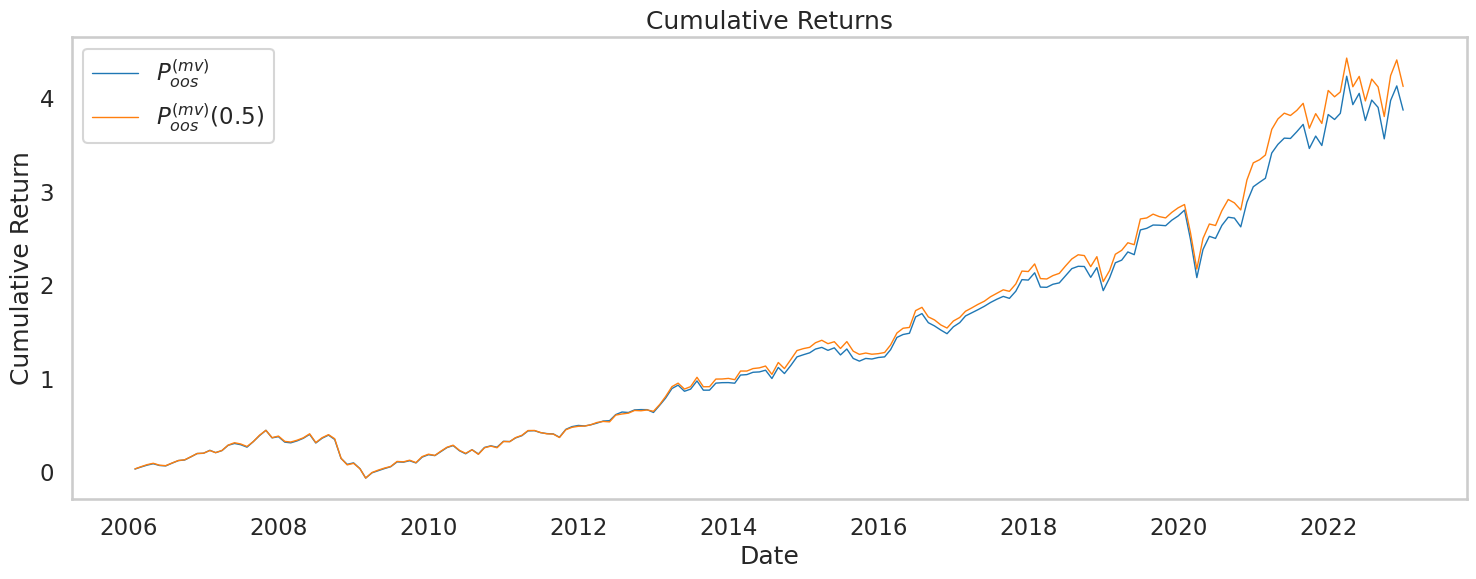

In [139]:
plot_cumulative_returns([performances, performances_mv05], ['$P_{oos}^{(mv)}$', '$P_{oos}^{(mv)}(0.5)$'])

2.3 Another interesting decarbonization strategy consists in designing the portfolio that is as close as possible to the benchmark, while reducing the carbon footprint by 25% (otherwise passive investor). This is done by maximizing the minimum variance criterion for the tracking error every year:

$$
\min_{\alpha_Y} \quad (TE_{p,Y})^2 = (\alpha_Y - \alpha_Y^{(vw)})'\Sigma_{Y+1} (\alpha_Y - \alpha_Y^{(vw)})
\\

s.t.\quad CF_Y^{(p)} \le 0.5 \times  CF_Y^{(P^{(vw)})}\\


s.t.\quad \alpha_{i,Y} \ge 0 \quad \quad \text{for all i}
$$

In [23]:
## Compute the yearly value-weighted portfolio weights
mv_y = market_value_y.iloc[:, market_value_y.columns.isin(range(2005, 2021+1))]
mv_y.columns = mv_y.columns + 1

yearly_total = mv_y.sum()

weights_vw_y = mv_y.div(yearly_total, axis=1)

## Compute the valued-weighted portfolio carbon footprint
total_emissions_per_year = carbon_emissions.sum()
total_emissions_per_year.index = total_emissions_per_year.index + 1
vw_cf = 1/yearly_total * total_emissions_per_year
vw_cf.name = "Carbon Footprint - P(VW)"
vw_cf

2006    211.728540
2007    194.834220
2008    197.539390
2009    308.428618
2010    220.243324
2011    205.018909
2012    208.085753
2013    178.922633
2014    141.983130
2015    131.761059
2016    133.093797
2017    129.154509
2018     99.322807
2019    107.203405
2020     81.693766
2021     65.442842
2022     54.353867
Name: Carbon Footprint - P(VW), dtype: float64

In [24]:
def tracking_error(weights, covmat, year):
    diff = weights - weights_vw_y[year]
    return np.dot(diff.T, np.dot(covmat, diff))

def carbon_footprint_constraint2(weights, year, money):
    ## Compute the carbon footprint of the year Y given its weights and the portfolio value at the end of year Y-1
    carbonfp = (((weights * money) / market_value_y[year-1]) * carbon_emissions[year-1] * 1/money).sum()
    target = vw_cf.loc[year] * 0.5

    return -(carbonfp - target)

In [25]:
# Number of Assets Constraint
n_assets = len(df_m.columns)

# Long Only Constraint (weights >= 0)
bounds = [(0, 1)] * n_assets

# Initial Guess (Equally Weighted Portfolio)
initial_weights = np.ones(n_assets) / n_assets

# Initial Date Range
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2005, 12, 31)
year = 2006

# Create a list to store the optimal weights
weights_vw05 = pd.DataFrame(index=df_m.columns)

initial_invest = 1_000_000
initial_weights = weights_df[year]

# 1-year rolling window minimium variance portfolio optimization
for i in range(17):
    covmat = compute_covmat(df_m, start, end)
    result = minimize(tracking_error, initial_weights, args=(covmat, year),
    constraints=[{'type': 'eq', 'fun': full_investment_constraint},
    {'type': 'ineq', 'fun': lambda x, year=year, initial_invest=initial_invest: carbon_footprint_constraint2(x, year, initial_invest)}], bounds=bounds)

    # Get optimal weights
    optimal_weights = result.x
    weights_vw05[end.year + 1] = optimal_weights

    initial_weights = optimal_weights.copy()
    # We need to update the initial_weights for the next iteration
    initial_invest = single_weights_to_new_investment_value(weights=optimal_weights, year=year, initial_invest=initial_invest)

    # Roll the window forward by 1 year
    start = start.replace(year=start.year+1)
    end = end.replace(year=end.year+1)
    year += 1


In [26]:
check_constraints(weights_vw05)

No error: Full investment constraint has been correctly applied.
No error: Long Only Constraint has been correctly applied.


In [27]:
performances_vw05 = from_alphas_to_perf(from_weights_to_alphas(weights_vw05))
vw05_cf = carbon_footprint(performances_vw05, weights_vw05, "P(VW)(0.5)")

pd.concat([vw_cf, vw05_cf], axis=1)

,Carbon Footprint - P(VW),Carbon Footprint - P(VW)(0.5)
2006,211.728540,105.86427
2007,194.834220,97.41711
2008,197.539390,98.769695
2009,308.428618,154.214309
2010,220.243324,101.093852
2011,205.018909,102.509455
2012,208.085753,104.042877
2013,178.922633,86.738071
2014,141.983130,70.991565
2015,131.761059,59.889418


In [28]:
characteristics_vw05 = pf_characteristics(performances_vw05, 'P(VW)(0.5)')
pd.concat([characteristics_vw, characteristics_vw05], axis=1)

,Value-Weighted Portfolio,P(VW)(0.5)
Annualized Average Return,0.103492,0.106119
Annualized Volatility,0.152565,0.153032
Sharpe Ratio,0.677653,0.693447
Minimum,-0.168004,-0.187801
Maximum,0.124161,0.118749
Maximum Drawdown,-0.478136,-0.469249


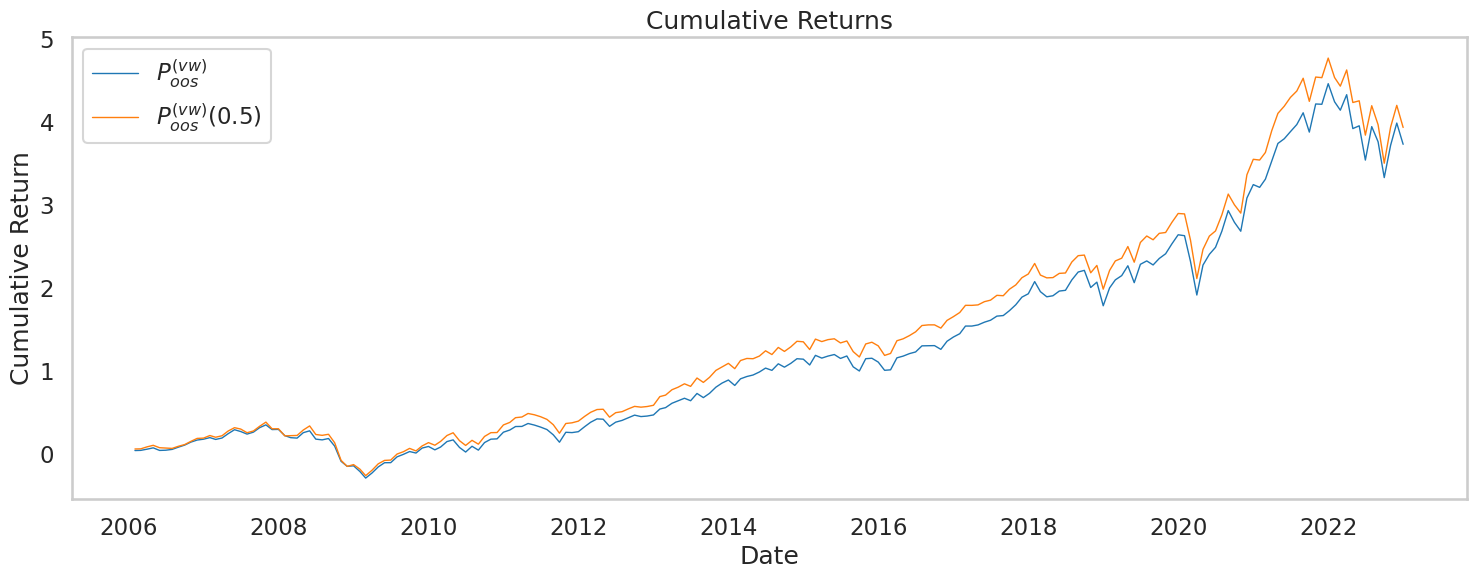

In [138]:
plot_cumulative_returns([performances_vwpf, performances_vw05], ['$P_{oos}^{(vw)}$', '$P_{oos}^{(vw)}(0.5)$'])

#### 3. Allocation with a Net Zero Objective

3.1 Implement a decarbonization strategy in which the carbon footprint of the portfolio is reduced by θ = 10% per year every year from Dec. 2005 to Dec. 2021.
We adopt the point of view of the otherwise passive investor. The optimization problem is the same as in point 2.3 except that the carbon emissions reduction constraint is now defined as:

$$CF_Y^{(p)} \le (1-\theta)^{Y-Y_0+1} \ \times \ CF_{Y_0}^{(P^{(vw)})}$$

In [30]:
def tracking_error2(weights, covmat, year):
    diff = weights - weights_vw_y[year]
    return np.dot(diff.T, np.dot(covmat, diff))

def carbon_footprint_constraint3(weights, year, money):
    ## Compute the carbon footprint of the year Y given its weights and the portfolio value at the end of year Y-1
    carbonfp = (((weights * money) / market_value_y[year-1]) * carbon_emissions[year-1] * 1/money).sum()
    target = 0.9 ** (year-2006+1) * vw_cf.loc[2006]

    return -(carbonfp - target)

In [31]:
# Number of Assets Constraint
n_assets = len(df_m.columns)

# Long Only Constraint (weights >= 0)
bounds = [(0, 1)] * n_assets

# Initial Date Range
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2005, 12, 31)
year = 2006

# Create a list to store the optimal weights
weights_vwnz = pd.DataFrame(index=df_m.columns)

initial_invest = 1_000_000

initial_weights = np.ones(n_assets) / n_assets

# 1-year rolling window minimium variance portfolio optimization
for i in range(17):
    covmat = compute_covmat(df_m, start, end)

    constraints = [
        {'type': 'eq', 'fun': full_investment_constraint},
        {'type': 'ineq', 'fun': lambda x, year=year, initial_invest=initial_invest: carbon_footprint_constraint3(x, year, initial_invest)}
    ]

    result = minimize(tracking_error2, initial_weights, args=(covmat, year), constraints=constraints, bounds=bounds)

    # Get optimal weights
    if result.success:
        optimal_weights = result.x
        weights_vwnz[end.year + 1] = optimal_weights
        
        # Update initial_invest for the next iteration
        initial_invest = single_weights_to_new_investment_value(weights=optimal_weights, year=year, initial_invest=initial_invest)
        
        # Update initial_weights for the next iteration
        initial_weights = optimal_weights
    else:
        print(f"Optimization failed for year {year}")

    # Roll the window forward by 1 year
    start = start.replace(year=start.year+1)
    end = end.replace(year=end.year+1)
    year += 1


In [32]:
check_constraints(weights_vwnz)

No error: Full investment constraint has been correctly applied.
No error: Long Only Constraint has been correctly applied.


In [33]:
performances_vwnz = from_alphas_to_perf(from_weights_to_alphas(weights_vwnz))
vwnz_cf = carbon_footprint(performances_vwnz, weights_vwnz, "P(VW)(NZ)")

pd.concat([vw_cf, vw05_cf, vwnz_cf], axis=1)

,Carbon Footprint - P(VW),Carbon Footprint - P(VW)(0.5),Carbon Footprint - P(VW)(NZ)
2006,211.728540,105.86427,190.555686
2007,194.834220,97.41711,171.500118
2008,197.539390,98.769695,147.300215
2009,308.428618,154.214309,138.915095
2010,220.243324,101.093852,105.599738
2011,205.018909,102.509455,99.755331
2012,208.085753,104.042877,101.269104
2013,178.922633,86.738071,89.63346
2014,141.983130,70.991565,71.710403
2015,131.761059,59.889418,67.507036


3.2 Compare the characteristics and the cumulative performance of the three portfolios $P_{oos}^{(vw)}$, $P_{oos}^{(vw)}(0.5)$, and $P_{oos}^{(vw)}(NZ)$

In [34]:
characteristics_vwnz = pf_characteristics(performances_vwnz, 'P(VW)(NZ)')
pd.concat([characteristics_vw, characteristics_vw05, characteristics_vwnz], axis=1)

,Value-Weighted Portfolio,P(VW)(0.5),P(VW)(NZ)
Annualized Average Return,0.103492,0.106119,0.104835
Annualized Volatility,0.152565,0.153032,0.154157
Sharpe Ratio,0.677653,0.693447,0.680051
Minimum,-0.168004,-0.187801,-0.180939
Maximum,0.124161,0.118749,0.121560
Maximum Drawdown,-0.478136,-0.469249,-0.480909


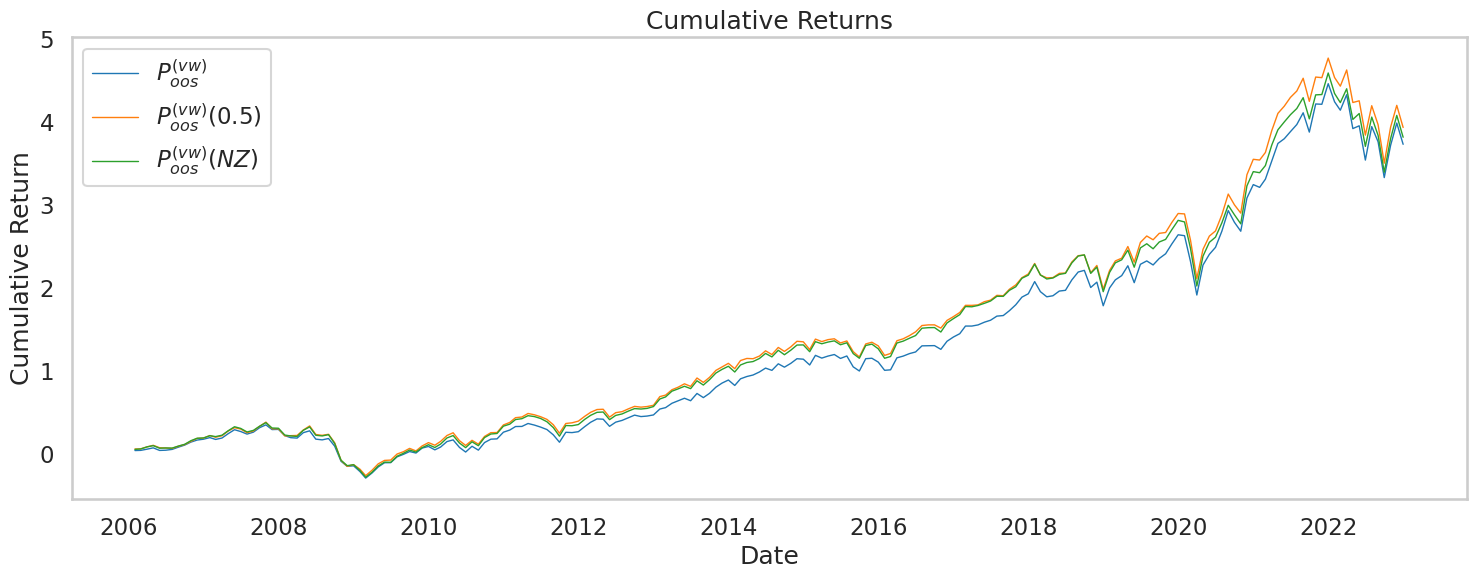

In [137]:
plot_cumulative_returns([performances_vwpf, performances_vw05, performances_vwnz], ['$P_{oos}^{(vw)}$', '$P_{oos}^{(vw)}(0.5)$', '$P_{oos}^{(vw)}(NZ)$'])

#### Some graphs for the report, and the presentation

In [39]:
sectors = companies[['Company', 'GICSSectorName']]
sectors = sectors.reset_index()[['Company', 'GICSSectorName']].set_index('Company')

In [44]:
def stacked_area_plot(weights_df, name):
    global sectors
    sectors_copy = sectors.copy()
    weights_df['sectors'] = sectors_copy
    sector_weights = weights_df.groupby('sectors').sum()

    sector_weights.T.plot(kind='area', 
                        stacked=True, 
                        colormap='tab20', 
                        figsize=(16, 8))

    plt.title(f'Sector Evolution - {name}')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4, fontsize='small')
    plt.grid(False)
    plt.tight_layout()
    plt.show()

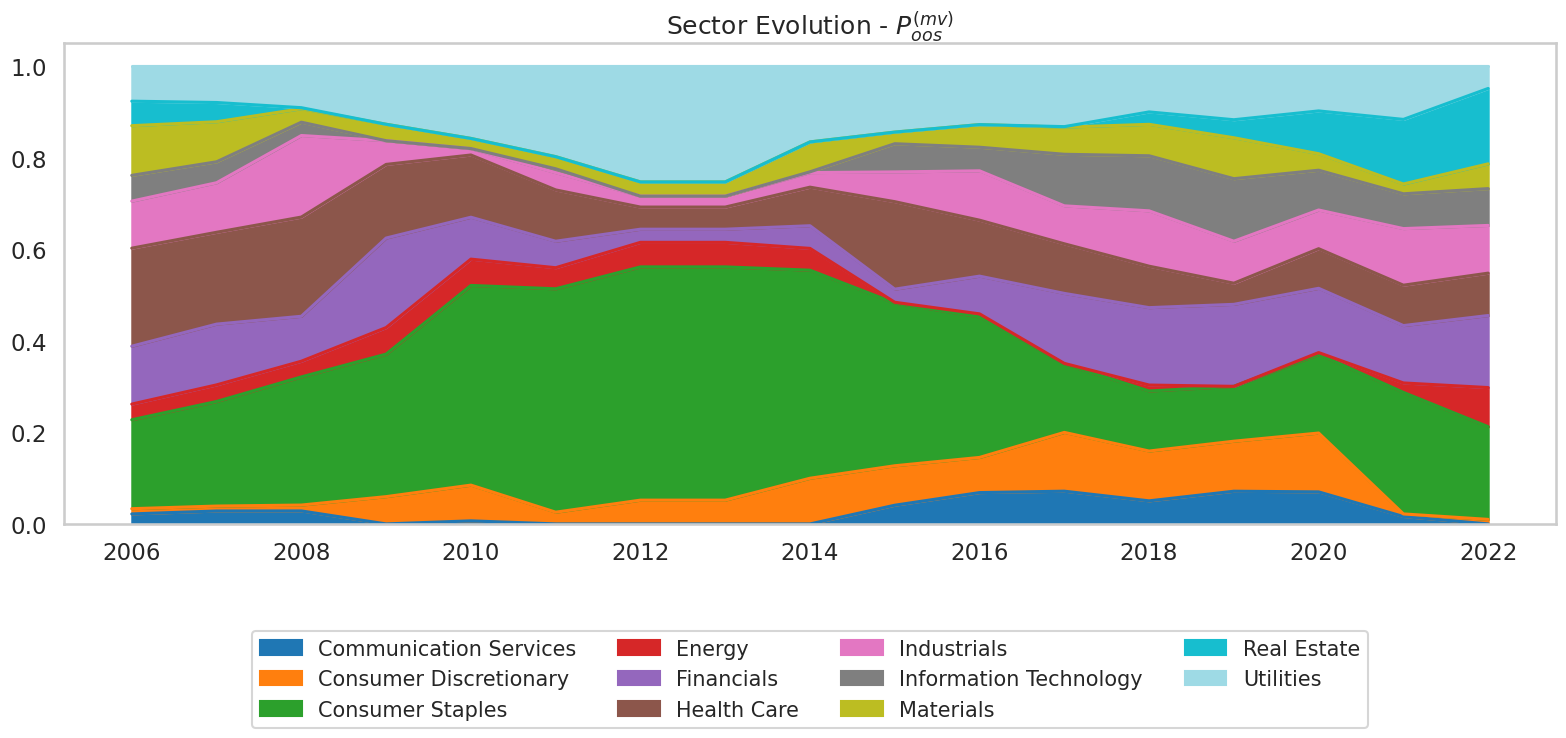

In [136]:
stacked_area_plot(weights_df, "$P^{(mv)}_{oos}$")

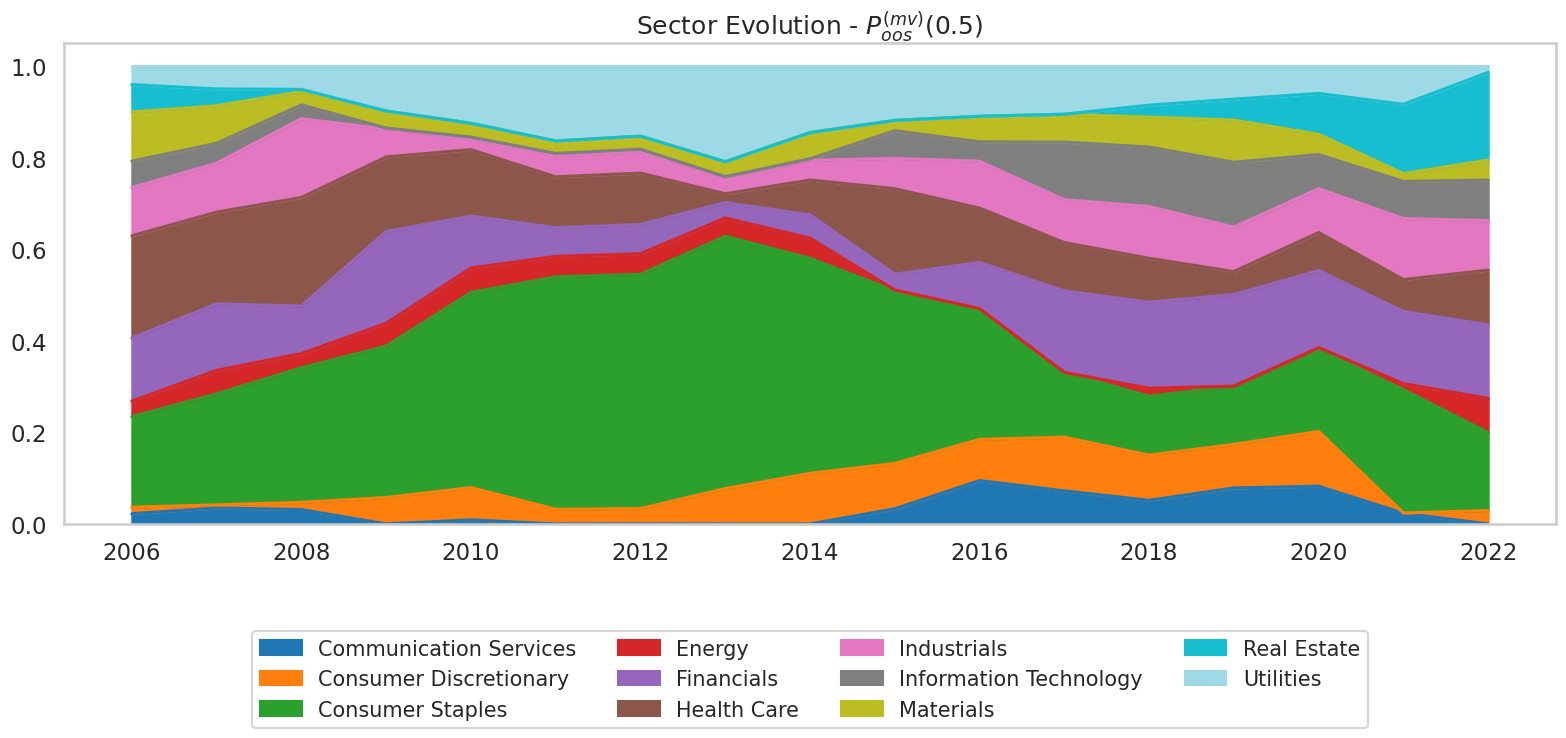

In [135]:
stacked_area_plot(weights_mv05, "$P^{(mv)}_{oos}(0.5)$")

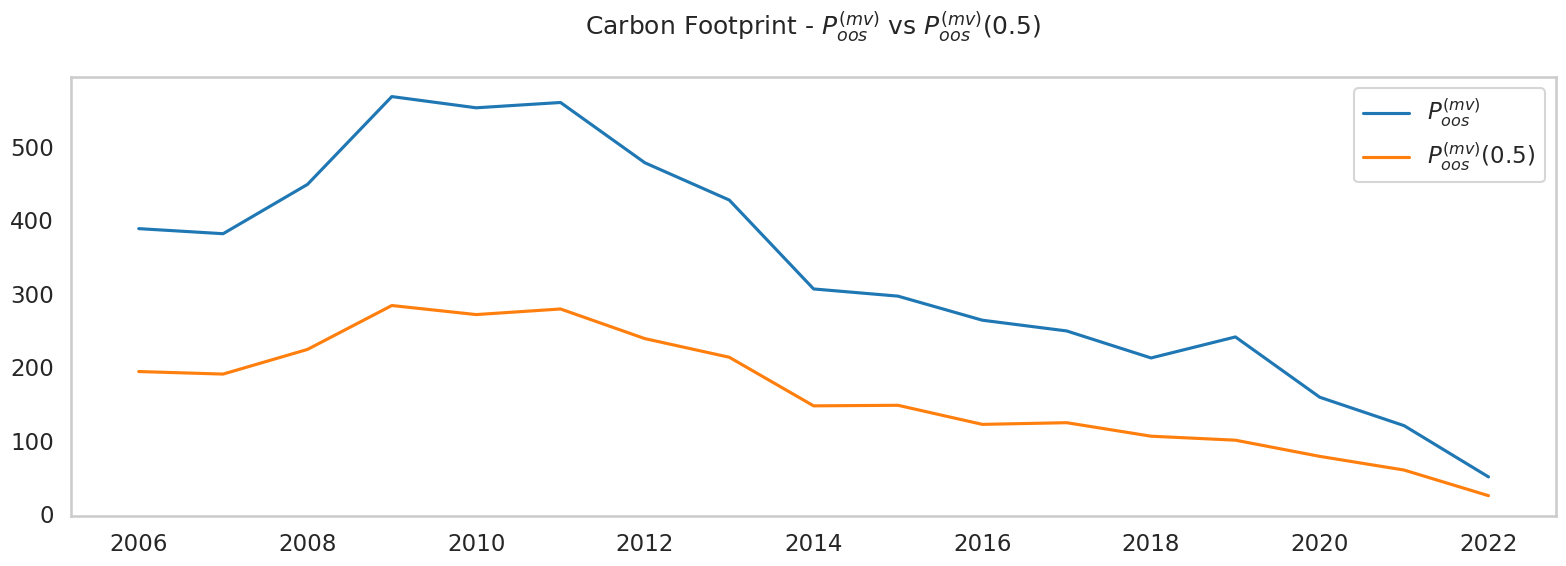

In [134]:
pd.concat([mv_cf, mv05_cf], axis=1).plot(kind='line', figsize=(16, 6))
plt.title('Carbon Footprint - $P^{(mv)}_{oos}$ vs $P^{(mv)}_{oos}(0.5)$\n')
plt.legend(['$P^{(mv)}_{oos}$', '$P^{(mv)}_{oos}(0.5)$'])
plt.grid(False)
plt.tight_layout()
plt.show()

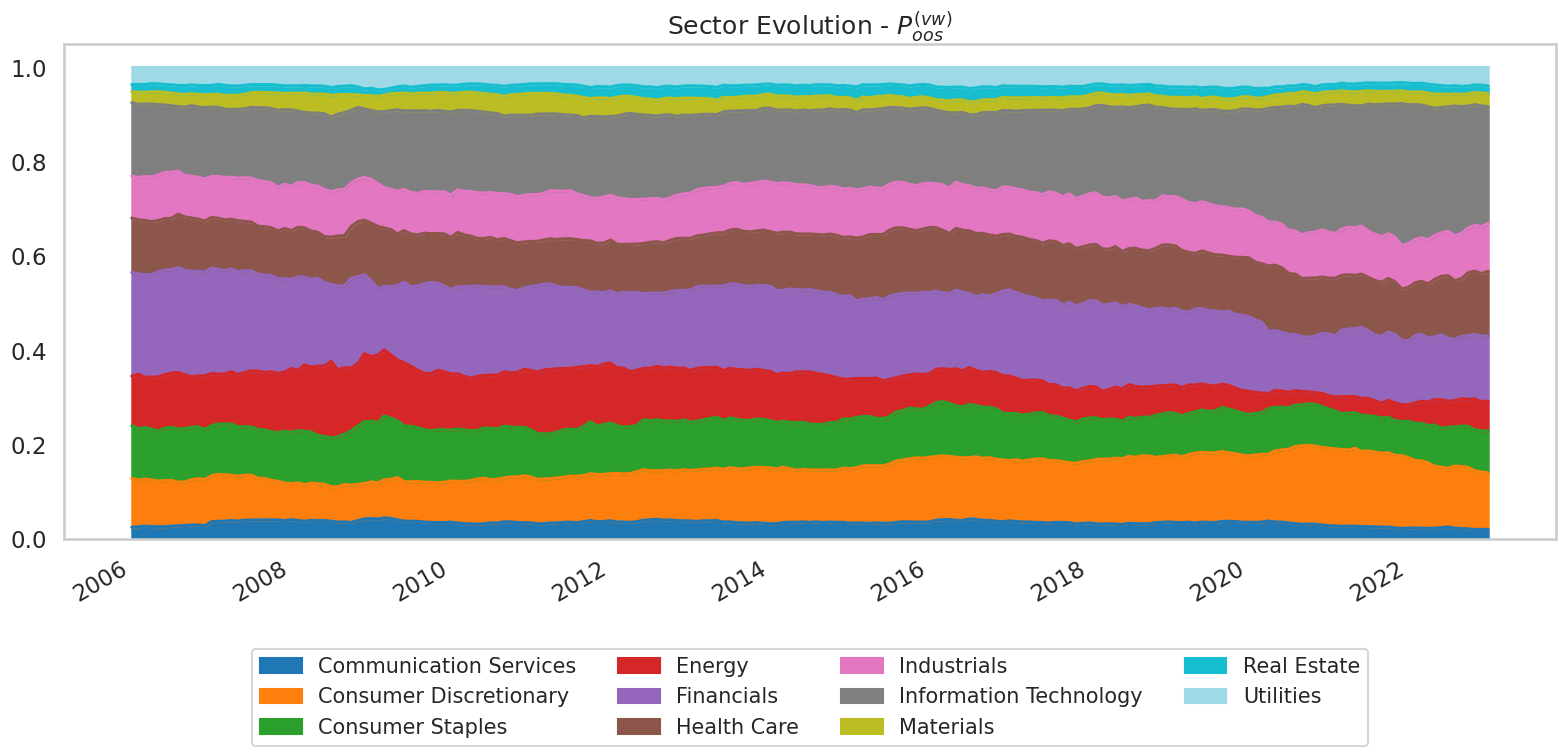

In [133]:
stacked_area_plot(weights_vwpf, "$P^{(vw)}_{oos}$")

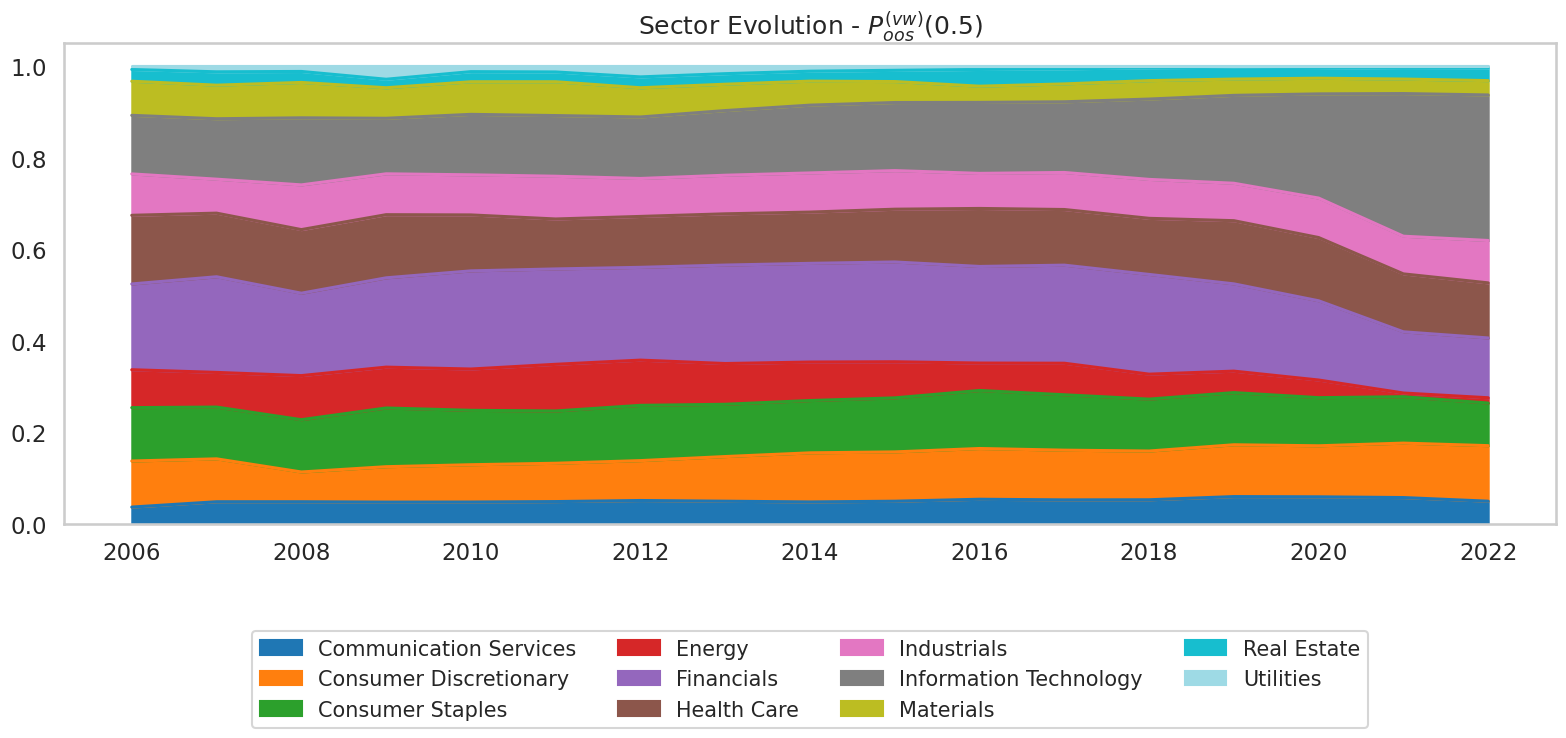

In [132]:
stacked_area_plot(weights_vw05, "$P^{(vw)}_{oos}(0.5)$")

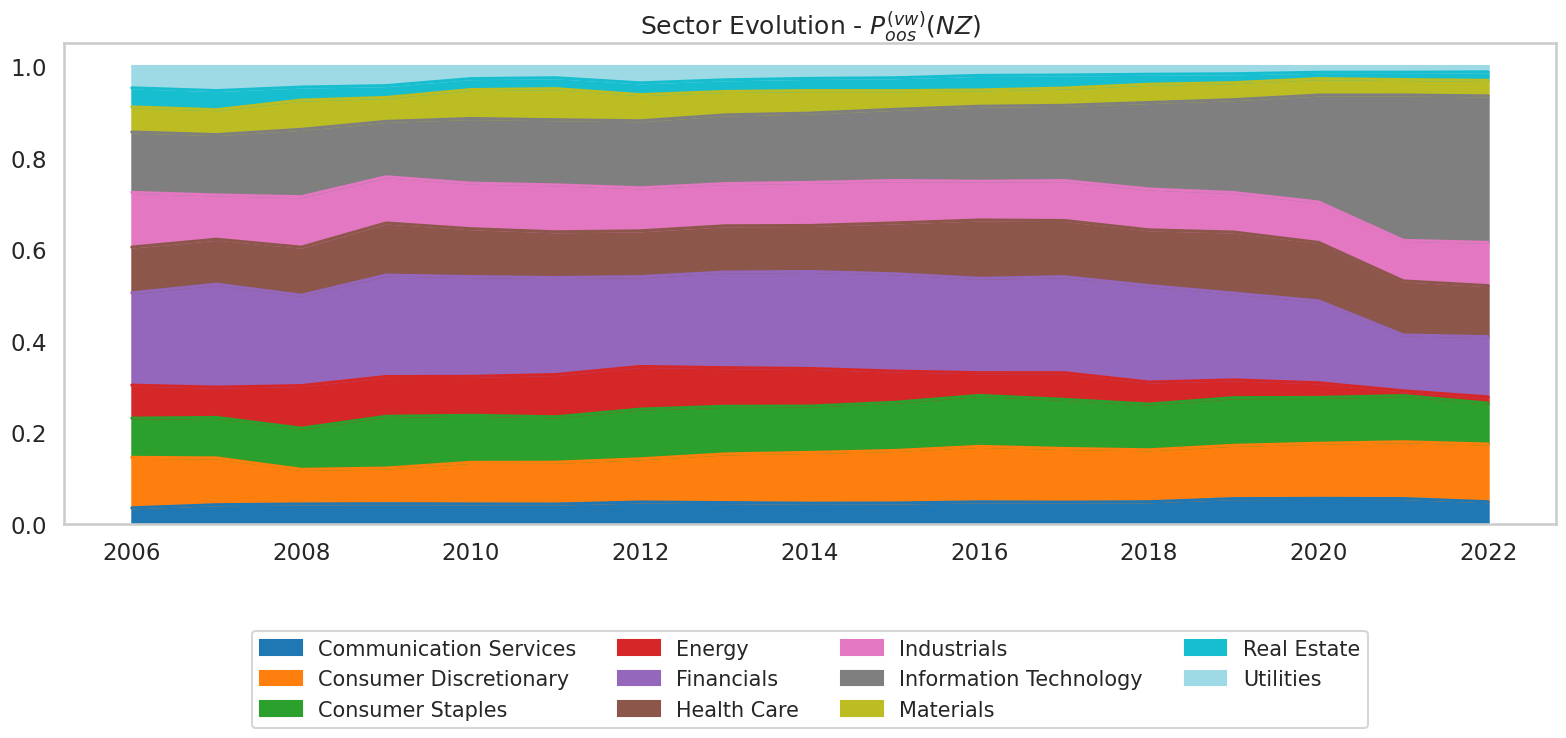

In [131]:
stacked_area_plot(weights_vwnz, "$P^{(vw)}_{oos}(NZ)$")

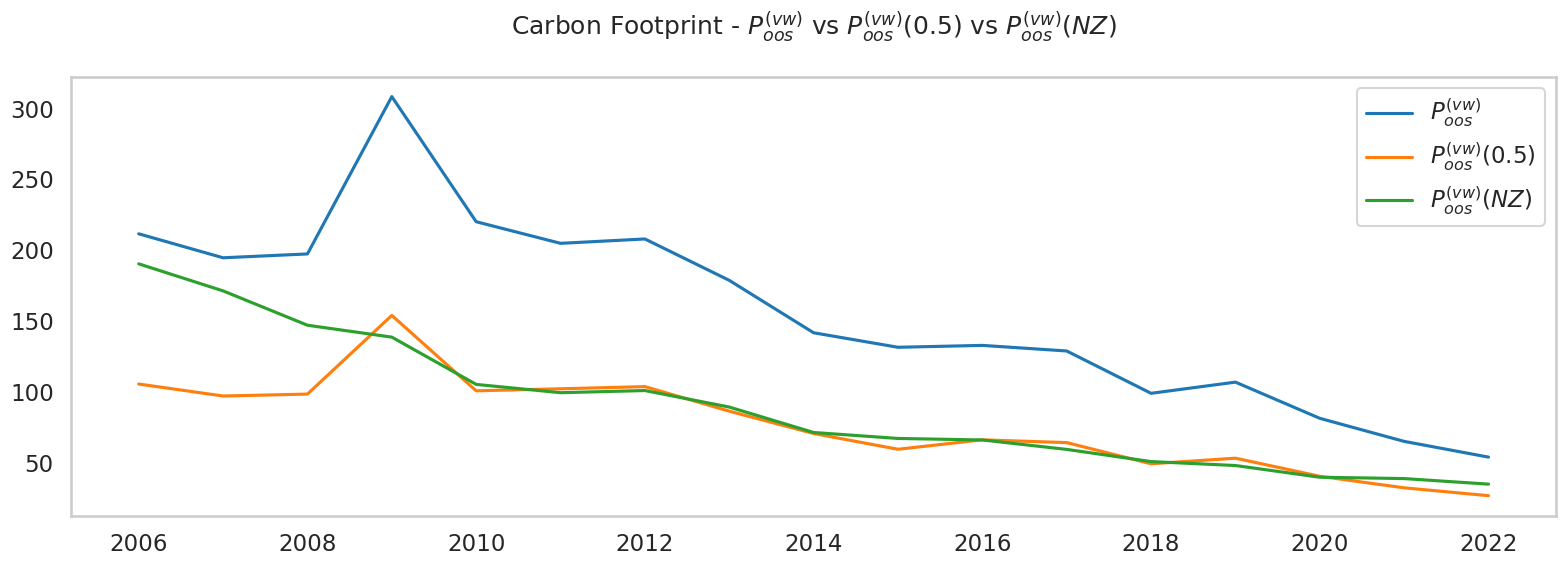

In [129]:
pd.concat([vw_cf, vw05_cf, vwnz_cf], axis=1).plot(kind='line', figsize=(16, 6))
plt.title('Carbon Footprint - $P^{(vw)}_{oos}$ vs $P^{(vw)}_{oos}(0.5)$ vs $P^{(vw)}_{oos}(NZ)$\n')
plt.legend(['$P^{(vw)}_{oos}$', '$P^{(vw)}_{oos}(0.5)$', '$P^{(vw)}_{oos}(NZ)$'])
plt.grid(False)
plt.tight_layout()
plt.show()

In [98]:
## 10 largest positions represents generally around 50 to 60% of our portfolio.

def n_largest_pos(weights_df, n=20):
    largest_pos = pd.DataFrame(columns=range(2006, 2022+1), index=range(n))

    for year in range(2006, 2022+1):
        largest_pos[year] = weights_df[year].nlargest(n).index

    return largest_pos

In [99]:
n_largest_pos(weights_df, 10)

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,The Hershey Company,The Hershey Company,The Hershey Company,Walmart Inc.,Walmart Inc.,Walmart Inc.,Walmart Inc.,Walmart Inc.,Walmart Inc.,"General Mills, Inc.","General Mills, Inc.",The Southern Company,The Southern Company,Empire Company Limited,Empire Company Limited,Equity Commonwealth,Equity Commonwealth
1,The Southern Company,The Southern Company,Medtronic plc,The Southern Company,"General Mills, Inc.","General Mills, Inc.","General Mills, Inc.","General Mills, Inc.","General Mills, Inc.",Walmart Inc.,Walmart Inc.,Walmart Inc.,"Capitol Federal Financial, Inc.",The Southern Company,Equity Commonwealth,Empire Company Limited,Coterra Energy Inc.
2,Medtronic plc,Medtronic plc,The Southern Company,"General Mills, Inc.",The Hershey Company,The Hershey Company,The Hershey Company,The Hershey Company,The Hershey Company,The Hershey Company,The Southern Company,Agnico Eagle Mines Limited,"Motorola Solutions, Inc.",Agnico Eagle Mines Limited,"Everest Group, Ltd.",Lindsay Corporation,Lindsay Corporation
3,"BlackRock, Inc.","BlackRock, Inc.","BlackRock, Inc.",W. R. Berkley Corporation,Quest Diagnostics Incorporated,The Southern Company,PG&E Corporation,PG&E Corporation,PG&E Corporation,"Stericycle, Inc.",International Business Machines Corporation,"Motorola Solutions, Inc.",Walmart Inc.,"Motorola Solutions, Inc.",Eli Lilly and Company,"FTI Consulting, Inc.","Capitol Federal Financial, Inc."
4,"Valhi, Inc.","Valhi, Inc.","FTI Consulting, Inc.",Medtronic plc,The Southern Company,Hormel Foods Corporation,The Southern Company,The Southern Company,"AutoZone, Inc.","The Cooper Companies, Inc.",The Hershey Company,McDonald's Corporation,Agnico Eagle Mines Limited,Crown Castle Inc.,The Southern Company,"Capitol Federal Financial, Inc.",Empire Company Limited
5,Public Storage,Imperial Oil Limited,Walmart Inc.,"Strategic Education, Inc.",Associated Banc-Corp,Quest Diagnostics Incorporated,"AutoZone, Inc.","AutoZone, Inc.","Capitol Federal Financial, Inc.",PG&E Corporation,"Stericycle, Inc.",Empire Company Limited,"Darden Restaurants, Inc.","Capitol Federal Financial, Inc.","Darden Restaurants, Inc.","Everest Group, Ltd.","Everest Group, Ltd."
6,Lockheed Martin Corporation,Lockheed Martin Corporation,"General Mills, Inc.",The Hershey Company,Hormel Foods Corporation,UGI Corporation,Range Resources Corporation,Range Resources Corporation,Monster Beverage Corporation,International Business Machines Corporation,"FTI Consulting, Inc.","Capitol Federal Financial, Inc.",Empire Company Limited,"Darden Restaurants, Inc.",Crown Castle Inc.,Public Storage,ResMed Inc.
7,The Procter & Gamble Company,Public Storage,Imperial Oil Limited,Quest Diagnostics Incorporated,"Strategic Education, Inc.",Abbott Laboratories,"Essential Utilities, Inc.","Essential Utilities, Inc.",The Southern Company,The Southern Company,The Cigna Group,Crown Castle Inc.,Crown Castle Inc.,Erie Indemnity Company,Agnico Eagle Mines Limited,"Activision Blizzard, Inc.",Public Storage
8,Agnico Eagle Mines Limited,"RB Global, Inc.","RB Global, Inc.","Church & Dwight Co., Inc.",Medtronic plc,Empire Company Limited,Kimberly-Clark Corporation,Kimberly-Clark Corporation,DaVita Inc.,Quest Diagnostics Incorporated,American Tower Corporation,Microsoft Corporation,McDonald's Corporation,Southern Copper Corporation,"FTI Consulting, Inc.",Hormel Foods Corporation,Metro Inc.
9,Imperial Oil Limited,Boston Scientific Corporation,"Stericycle, Inc.",First Horizon Corporation,UGI Corporation,Range Resources Corporation,PPL Corporation,PPL Corporation,Range Resources Corporation,"Tyson Foods, Inc.",McDonald's Corporation,Lockheed Martin Corporation,Lockheed Martin Corporation,PG&E Corporation,Lindsay Corporation,Metro Inc.,The J. M. Smucker Company


In [102]:
n_largest_pos(weights_mv05, 10)

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,The Hershey Company,The Hershey Company,The Hershey Company,Walmart Inc.,Walmart Inc.,Walmart Inc.,Walmart Inc.,Walmart Inc.,"General Mills, Inc.","General Mills, Inc.","General Mills, Inc.","Capitol Federal Financial, Inc.","Capitol Federal Financial, Inc.",Empire Company Limited,Empire Company Limited,Equity Commonwealth,Equity Commonwealth
1,Medtronic plc,Medtronic plc,Medtronic plc,"General Mills, Inc.","General Mills, Inc.","General Mills, Inc.","General Mills, Inc.","General Mills, Inc.",Walmart Inc.,Walmart Inc.,Walmart Inc.,"Motorola Solutions, Inc.","Motorola Solutions, Inc.","Capitol Federal Financial, Inc.",Eli Lilly and Company,"Capitol Federal Financial, Inc.","Capitol Federal Financial, Inc."
2,"BlackRock, Inc.","BlackRock, Inc.","BlackRock, Inc.",Medtronic plc,The Hershey Company,The Hershey Company,The Hershey Company,The Hershey Company,PG&E Corporation,The Hershey Company,The Cigna Group,Walmart Inc.,Walmart Inc.,Agnico Eagle Mines Limited,"Everest Group, Ltd.",Empire Company Limited,Coterra Energy Inc.
3,Public Storage,"Valhi, Inc.","FTI Consulting, Inc.",The Hershey Company,Quest Diagnostics Incorporated,Hormel Foods Corporation,Hormel Foods Corporation,PG&E Corporation,The Hershey Company,PG&E Corporation,Crown Castle Inc.,Agnico Eagle Mines Limited,Agnico Eagle Mines Limited,Crown Castle Inc.,Crown Castle Inc.,"FTI Consulting, Inc.",Lindsay Corporation
4,"Valhi, Inc.",Imperial Oil Limited,Walmart Inc.,W. R. Berkley Corporation,Medtronic plc,Quest Diagnostics Incorporated,Quest Diagnostics Incorporated,"Essential Utilities, Inc.",Monster Beverage Corporation,"Stericycle, Inc.",International Business Machines Corporation,Crown Castle Inc.,Crown Castle Inc.,"Motorola Solutions, Inc.",Equity Commonwealth,Public Storage,"Everest Group, Ltd."
5,Lockheed Martin Corporation,BCE Inc.,"General Mills, Inc.","Strategic Education, Inc.",Associated Banc-Corp,DaVita Inc.,DaVita Inc.,"AutoZone, Inc.","Capitol Federal Financial, Inc.","The Cooper Companies, Inc.","FTI Consulting, Inc.",McDonald's Corporation,"Darden Restaurants, Inc.",Erie Indemnity Company,"Darden Restaurants, Inc.",Lindsay Corporation,ResMed Inc.
6,The Procter & Gamble Company,"RB Global, Inc.",BCE Inc.,Quest Diagnostics Incorporated,"Strategic Education, Inc.",PG&E Corporation,PG&E Corporation,Hormel Foods Corporation,"AutoZone, Inc.",International Business Machines Corporation,American Tower Corporation,Empire Company Limited,"Consolidated Edison, Inc.","Darden Restaurants, Inc.","Capitol Federal Financial, Inc.","Everest Group, Ltd.",Public Storage
7,Agnico Eagle Mines Limited,Lockheed Martin Corporation,"RB Global, Inc.","FTI Consulting, Inc.",Hormel Foods Corporation,UGI Corporation,"Essential Utilities, Inc.","Consolidated Edison, Inc.","Stericycle, Inc.",Quest Diagnostics Incorporated,PG&E Corporation,"Consolidated Edison, Inc.",McDonald's Corporation,Southern Copper Corporation,"FTI Consulting, Inc.","Activision Blizzard, Inc.",Metro Inc.
8,Boston Scientific Corporation,Markel Group Inc.,"IDEXX Laboratories, Inc.","Church & Dwight Co., Inc.",Exxon Mobil Corporation,"Essential Utilities, Inc.",UGI Corporation,Range Resources Corporation,DaVita Inc.,"AutoZone, Inc.",McDonald's Corporation,Microsoft Corporation,Empire Company Limited,PG&E Corporation,Agnico Eagle Mines Limited,Metro Inc.,"Akamai Technologies, Inc."
9,Imperial Oil Limited,Public Storage,Imperial Oil Limited,First Horizon Corporation,UGI Corporation,Abbott Laboratories,Abbott Laboratories,"Stericycle, Inc.","Consolidated Edison, Inc.","O'Reilly Automotive, Inc.","Consolidated Edison, Inc.",Lockheed Martin Corporation,Microsoft Corporation,"Everest Group, Ltd.",Lindsay Corporation,Hormel Foods Corporation,"Regeneron Pharmaceuticals, Inc."


In [103]:
n_largest_pos(weights_vw05, 10)

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,The Hershey Company,The Hershey Company,The Hershey Company,The Hershey Company,The Hershey Company,The Hershey Company,The Hershey Company,The Hershey Company,The Hershey Company,The Hershey Company,The Hershey Company,The Hershey Company,The Hershey Company,The Hershey Company,The Hershey Company,Apple Inc.,Apple Inc.
1,Medtronic plc,Medtronic plc,Medtronic plc,Medtronic plc,Medtronic plc,Medtronic plc,Medtronic plc,Medtronic plc,Medtronic plc,Medtronic plc,Medtronic plc,Medtronic plc,Medtronic plc,Medtronic plc,Medtronic plc,Microsoft Corporation,Microsoft Corporation
2,"BlackRock, Inc.","BlackRock, Inc.","BlackRock, Inc.","BlackRock, Inc.","BlackRock, Inc.","BlackRock, Inc.","BlackRock, Inc.","BlackRock, Inc.","Merck & Co., Inc.","Merck & Co., Inc.","Merck & Co., Inc.","Merck & Co., Inc.",Microsoft Corporation,Microsoft Corporation,Microsoft Corporation,The Hershey Company,The Hershey Company
3,The Procter & Gamble Company,"Merck & Co., Inc.","Merck & Co., Inc.",The Procter & Gamble Company,The Procter & Gamble Company,The Procter & Gamble Company,The Procter & Gamble Company,The Procter & Gamble Company,"BlackRock, Inc.",The Procter & Gamble Company,The Procter & Gamble Company,Microsoft Corporation,"Merck & Co., Inc.","Merck & Co., Inc.",Apple Inc.,"Amazon.com, Inc.","Amazon.com, Inc."
4,Imperial Oil Limited,The Procter & Gamble Company,The Procter & Gamble Company,"Merck & Co., Inc.","Merck & Co., Inc.","Merck & Co., Inc.","Merck & Co., Inc.","Merck & Co., Inc.",The Procter & Gamble Company,"BlackRock, Inc.",Microsoft Corporation,The Procter & Gamble Company,"BlackRock, Inc.",Apple Inc.,"Amazon.com, Inc.",Medtronic plc,Medtronic plc
5,Public Storage,Imperial Oil Limited,Imperial Oil Limited,Imperial Oil Limited,Imperial Oil Limited,Imperial Oil Limited,Imperial Oil Limited,Microsoft Corporation,Microsoft Corporation,Microsoft Corporation,"BlackRock, Inc.","BlackRock, Inc.",The Procter & Gamble Company,"BlackRock, Inc.","BlackRock, Inc.","BlackRock, Inc.","BlackRock, Inc."
6,Markel Group Inc.,Lockheed Martin Corporation,Lockheed Martin Corporation,Lockheed Martin Corporation,Microsoft Corporation,Microsoft Corporation,Microsoft Corporation,Imperial Oil Limited,Imperial Oil Limited,Lockheed Martin Corporation,Lockheed Martin Corporation,Lockheed Martin Corporation,Apple Inc.,The Procter & Gamble Company,"Merck & Co., Inc.","Merck & Co., Inc.","Merck & Co., Inc."
7,"Merck & Co., Inc.",Markel Group Inc.,Markel Group Inc.,Microsoft Corporation,Lockheed Martin Corporation,Lockheed Martin Corporation,Lockheed Martin Corporation,Lockheed Martin Corporation,Lockheed Martin Corporation,Imperial Oil Limited,Verizon Communications Inc.,Verizon Communications Inc.,Lockheed Martin Corporation,Lockheed Martin Corporation,The Procter & Gamble Company,The Procter & Gamble Company,NVIDIA Corporation
8,"Valhi, Inc.",Public Storage,Microsoft Corporation,Markel Group Inc.,Markel Group Inc.,Markel Group Inc.,Markel Group Inc.,Markel Group Inc.,Markel Group Inc.,Markel Group Inc.,Markel Group Inc.,Apple Inc.,Markel Group Inc.,"Amazon.com, Inc.",Lockheed Martin Corporation,Lockheed Martin Corporation,The Procter & Gamble Company
9,Lockheed Martin Corporation,Huntington Bancshares Incorporated,Public Storage,Ball Corporation,Ball Corporation,Verizon Communications Inc.,Verizon Communications Inc.,Verizon Communications Inc.,Verizon Communications Inc.,Verizon Communications Inc.,Imperial Oil Limited,Markel Group Inc.,Verizon Communications Inc.,Verizon Communications Inc.,Verizon Communications Inc.,Verizon Communications Inc.,Verizon Communications Inc.


In [104]:
n_largest_pos(weights_vwnz, 10)

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,"Merck & Co., Inc.","Merck & Co., Inc.","Merck & Co., Inc.","Merck & Co., Inc.","Merck & Co., Inc.","Merck & Co., Inc.",Apple Inc.,Apple Inc.,Apple Inc.,Apple Inc.,Apple Inc.,Apple Inc.,Apple Inc.,Apple Inc.,Apple Inc.,Apple Inc.,Apple Inc.
1,Verizon Communications Inc.,Verizon Communications Inc.,Apple Inc.,Verizon Communications Inc.,Microsoft Corporation,Microsoft Corporation,"Merck & Co., Inc.","Merck & Co., Inc.","Merck & Co., Inc.","Merck & Co., Inc.",Microsoft Corporation,Microsoft Corporation,Microsoft Corporation,Microsoft Corporation,Microsoft Corporation,Microsoft Corporation,Microsoft Corporation
2,Microsoft Corporation,AT&T Inc.,Verizon Communications Inc.,Exxon Mobil Corporation,Apple Inc.,Apple Inc.,Microsoft Corporation,Microsoft Corporation,Microsoft Corporation,Microsoft Corporation,"Merck & Co., Inc.","Merck & Co., Inc.","Merck & Co., Inc.","Merck & Co., Inc.","Amazon.com, Inc.","Amazon.com, Inc.","Amazon.com, Inc."
3,AT&T Inc.,Microsoft Corporation,Microsoft Corporation,Microsoft Corporation,Exxon Mobil Corporation,Exxon Mobil Corporation,Exxon Mobil Corporation,Exxon Mobil Corporation,Exxon Mobil Corporation,Exxon Mobil Corporation,Verizon Communications Inc.,Exxon Mobil Corporation,Exxon Mobil Corporation,"Amazon.com, Inc.","Merck & Co., Inc.",QUALCOMM Incorporated,QUALCOMM Incorporated
4,QUALCOMM Incorporated,Pfizer Inc.,AT&T Inc.,AT&T Inc.,Verizon Communications Inc.,Verizon Communications Inc.,Verizon Communications Inc.,Verizon Communications Inc.,Verizon Communications Inc.,Verizon Communications Inc.,Exxon Mobil Corporation,Verizon Communications Inc.,Verizon Communications Inc.,Verizon Communications Inc.,Intel Corporation,NVIDIA Corporation,NVIDIA Corporation
5,Pfizer Inc.,Citigroup Inc.,Exxon Mobil Corporation,Pfizer Inc.,AT&T Inc.,AT&T Inc.,AT&T Inc.,AT&T Inc.,AT&T Inc.,AT&T Inc.,AT&T Inc.,AT&T Inc.,Intel Corporation,Intel Corporation,Verizon Communications Inc.,Intel Corporation,Adobe Inc.
6,Citigroup Inc.,"American International Group, Inc.",Pfizer Inc.,Apple Inc.,Pfizer Inc.,Pfizer Inc.,Pfizer Inc.,Pfizer Inc.,Pfizer Inc.,Intel Corporation,Intel Corporation,Intel Corporation,AT&T Inc.,Exxon Mobil Corporation,QUALCOMM Incorporated,Adobe Inc.,Intel Corporation
7,International Business Machines Corporation,Exxon Mobil Corporation,Intel Corporation,Johnson & Johnson,Intel Corporation,Intel Corporation,Intel Corporation,Intel Corporation,Intel Corporation,Pfizer Inc.,Pfizer Inc.,Pfizer Inc.,Pfizer Inc.,Pfizer Inc.,Exxon Mobil Corporation,"Merck & Co., Inc.","Merck & Co., Inc."
8,Intel Corporation,Apple Inc.,ConocoPhillips,Chevron Corporation,International Business Machines Corporation,ConocoPhillips,International Business Machines Corporation,International Business Machines Corporation,International Business Machines Corporation,International Business Machines Corporation,International Business Machines Corporation,International Business Machines Corporation,"Amazon.com, Inc.",McDonald's Corporation,Pfizer Inc.,Verizon Communications Inc.,Verizon Communications Inc.
9,"American International Group, Inc.",Rogers Communications Inc.,International Business Machines Corporation,ConocoPhillips,ConocoPhillips,International Business Machines Corporation,Chevron Corporation,Chevron Corporation,Chevron Corporation,Chevron Corporation,McDonald's Corporation,McDonald's Corporation,International Business Machines Corporation,AT&T Inc.,McDonald's Corporation,McDonald's Corporation,McDonald's Corporation
